# 🛒 E-commerce Sales & Behavior Analysis
## Project Objective
This project analyzes a large e-commerce event dataset (56 million rows) to understand customer behavior and identify key drivers of revenue. The goal is to move beyond simple reporting to uncover actionable insights.

### Analysis Workflow:
1.  **Data Cleaning & Preparation:** Efficiently load and clean the 56M row dataset using vectorized operations.
2.  **Sales Performance Analysis:** Identify top products, brands, and categories driving revenue.
3.  **Behavioral Funnel Analysis:** Correctly model the user conversion funnel (View → Cart → Purchase) on a session basis.
4.  **Cart Abandonment Insights:** Analyze *which* products are most frequently left in abandoned carts.
5.  **Customer Retention (Cohort Analysis):** Track user cohorts to understand customer loyalty and retention over time.
6.  **Predictive Modeling:** Build a RandomForest model to predict the likelihood of a user making a purchase based on their browsing behavior.


# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import joblib

# ML Libraries
# Import the ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve,confusion_matrix, classification_report)
# Set default plot themes
sns.set_theme(style="whitegrid")
pio.templates.default = "plotly_white"

## 2. Data Loading, Cleaning & Feature Engineering
We will load the data using efficient practices for a 56M row dataset.
1.  **Specify dtypes:** Reduces memory usage.
2.  **Specify format:** Speeds up `pd.to_datetime` significantly.
3.  **Vectorized Operations:** Use `.str.split()` instead of `.apply()` for feature extraction.

In [2]:
file_path = r"C:\Users\npsta\Downloads\2020-Jan.csv"

### 2.1 Load a small dataset

In [3]:
sample_df = pd.read_csv(file_path, nrows = 10000)
sample_df.head(10)

event_time event_type  product_id          category_id  \
0  2020-01-01 00:00:00 UTC       view     1005073  2232732093077520756   
1  2020-01-01 00:00:01 UTC       view     1005192  2232732093077520756   
2  2020-01-01 00:00:01 UTC       view   100063693  2053013552427434207   
3  2020-01-01 00:00:01 UTC       view     5100816  2232732103831716449   
4  2020-01-01 00:00:02 UTC       view   100014325  2232732103294845523   
5  2020-01-01 00:00:02 UTC       view    16500026  2232732108713886406   
6  2020-01-01 00:00:02 UTC       view     1802026  2232732099754852875   
7  2020-01-01 00:00:02 UTC       view    11600004  2053013554834964853   
8  2020-01-01 00:00:02 UTC       view     4802273  2232732079706079299   
9  2020-01-01 00:00:03 UTC       view     1005115  2232732093077520756   

                  category_code    brand    price    user_id  \
0      construction.tools.light  samsung  1130.02  519698804   
1      construction.tools.light    meizu   205.67  527767423   
2                 apparel.shirt   turtle   136.43  519046195   
3                 apparel.shoes   xiaomi    29.95  518269232   
4        apparel.shoes.step_ins    intel   167.20  587748686   
5               apparel.costume    gamma    37.35  581037554   
6  appliances.personal.massager  samsung   576.33  581274910   
7     appliances.kitchen.kettle     sven    43.48  595265136   
8                 sport.bicycle  samsung     6.64  595414563   
9      construction.tools.light    apple   869.46  531140669   

                           user_session  
0  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0  
1  7f596032-ccbf-4643-9bad-e36a209512b4  
2  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e  
3  0444841c-38ef-410c-b11f-7b35ea4e5991  
4  31b7d4cf-dfac-4895-9927-90fa3254f860  
5  c161400e-630b-4b59-8797-d9b9714444bf  
6  44ca9bc7-3ba8-4546-bdf5-10b2172ed883  
7  32c08a07-f2d0-4da5-83fd-40ce97c651e6  
8  176fd102-7b61-4452-a0e5-f1f8cc9b4b95  
9  84c838d4-6e10-4b7d-8d29-90749e577a6b

In [4]:
sample_df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [5]:
# Define dtypes for memory efficiency
dtypes = {
'event_type': 'category',
'product_id': 'int32',
'category_id': 'int64',
'category_code': 'str',
'brand': 'str',
'price': 'float32',
'user_id': 'int32',
'user_session': 'str'}

df = pd.read_csv(file_path,dtype = dtypes,parse_dates = ['event_time'],date_format = '%Y-%m-%d %H:%M:%S UTC'
)                

print("Data loaded successfully.")
print(f"Shape of the dataset: {df.shape}")
      

Data loaded successfully.
Shape of the dataset: (55967041, 9)


### 2.2 Data Cleaning & Feature Engineering

In [6]:
# Drop Duplicates
df.drop_duplicates(inplace = True)

### Fixing and Verifying Missing Data

In this step, we'll clean the 11.5 million missing values in category_code and brand.

Instead of just deleting these rows (which would lose 11% of our data) or filling them with "Unknown" (which is inaccurate), we will recover the missing information.

My logic is:

- For Categories: A category_id will always have the same category_code.

- For Brands: A product_id will always have the same brand.

- We will create "lookup maps" from the data we do have to fill in the data that's missing.

- Instead of dropping rows with missing data, the project recovered over 11.5 million missing values for category_code and brand.

- Method: It used a groupby().transform() method to fill missing brand names based on their product_id and missing category_code    based on their category_id.

- Result: This reduced missing values for these columns from over 5 million and 6.5 million (respectively) down to zero.

In [7]:
# Handle missing values

# --- a: Count Missing Values BEFORE ---
print("--- BEFORE CLEANING ---")
print(df.isnull().sum())
print("-" * 30)

# --- b: Fixing Missing Category Codes ---
print("Fixing missing category codes...")
category_mode = df.groupby('category_id')['category_code'].transform(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
df['category_code'] = category_mode


# --- c: Fixing Missing Brands ---
print("Fixing missing brands...")
brand_mode = df.groupby('product_id')['brand'].transform(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
df['brand'] = brand_mode

# --- d: Handle Any Leftovers ---
# Fill the few remaining blanks with 'Unknown'
df['category_code'] = df['category_code'].fillna('Unknown')
df['brand'] = df['brand'].fillna('Unknown')

# Drop the 19 rows with no session ID
df.dropna(subset=['user_session'], inplace=True)
df.drop_duplicates(inplace=True)

print("Fixing complete.")
print("\n--- AFTER CLEANING ---")
print(df.isnull().sum())
print("-" * 30)

# --- e: Check for Data Consistency ---
print("Verifying data consistency...")

# 1. Check for product_id <> brand conflicts
product_brands = df.groupby('product_id')['brand'].nunique()
brand_conflicts = product_brands[product_brands > 1].count()
print(f"Products found with inconsistent brand names: {brand_conflicts}")

# 2. Check for category_id <> category_code conflicts
category_codes = df.groupby('category_id')['category_code'].nunique()
code_conflicts = category_codes[category_codes > 1].count()
print(f"Categories found with inconsistent codes: {code_conflicts}")

print("-" * 30)
print("Data Handleing is done.")

--- BEFORE CLEANING ---
event_time             0
event_type             0
product_id             0
category_id            0
category_code    5034766
brand            6527940
price                  0
user_id                0
user_session          19
dtype: int64
------------------------------
Fixing missing category codes...
Fixing missing brands...
Fixing complete.

--- AFTER CLEANING ---
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64
------------------------------
Verifying data consistency...
Products found with inconsistent brand names: 0
Categories found with inconsistent codes: 0
------------------------------
Data Handleing is done.


### 2.3 Feature Engineering

In [8]:
# clean the category_code column ---
cat_cols = ['category_l1','category_l2','category_l3']
df[cat_cols] = df['category_code'].str.split('.',expand = True, n=2)
# Fill NaN with None
for col in cat_cols:
    df[col] = df[col].fillna('None')

In [9]:
# Time Featuring
df['event_hour'] = df['event_time'].dt.hour
df['event_weekday'] = df['event_time'].dt.day_name().str.capitalize()

In [10]:
# Column for Funnel Analysis
df['is_view'] = (df['event_type'] == 'view').astype(int)
df['is_cart'] = (df['event_type'] == 'cart').astype(int)
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)

In [11]:
# Column for Revenue
df['revenue'] = 0.0
df.loc[df['is_purchase'] ==1,'revenue'] = df['price']
print("Data Cleaning and Feature Engineering is complete.")

Data Cleaning and Feature Engineering is complete.


### Insight

- Categorical Features: The category_code (e.g., construction.tools.light) was split into three hierarchical columns (category_l1, category_l2, category_l3) for more granular analysis.

- Temporal Features: event_hour and event_weekday were extracted from the event_time column to analyze time-based behavior.

- Behavioral Flags: New columns (is_view, is_cart, is_purchase) were created to enable session-level funnel analysis.

- Financial Metric: A revenue column was created by calculating sales from price only on purchase events.

## 3. Behavioral Analysis: Conversion Funnel & Cart Abandonment

### 3.1 Session-Level Funnel Analysis

In [12]:
# Aggregate event types for each session
session_event = df.groupby('user_session')['event_type'].apply(set)

In [13]:
total_sessions = len(session_event)
view_sessions = session_event.apply(lambda x: 'view' in x).sum()
cart_sessions = session_event.apply(lambda x: 'cart' in x).sum()
purchase_sessions = session_event.apply(lambda x: 'purchase' in x).sum()

In [14]:
# Calculate the True Conversion Rates
# a) View to cart
view_to_cart_sessions = session_event.apply(lambda x: 'view' in x and 'cart' in x).sum()
view_to_cart_rate = (view_to_cart_sessions / view_sessions)

# b) cart to purchase
cart_to_purchase_sessions = session_event.apply(lambda x: 'cart' in x and 'purchase' in x).sum()
cart_to_purchase_rate = (cart_to_purchase_sessions / cart_sessions)

# c) overall purchase rate
overall_conversion_rate = (purchase_sessions / total_sessions)

# d) abandonment rate
abandoned_sessions = session_event.apply(lambda x: 'cart' in x and 'purchase' not in x).sum()
abandonment_rate = (abandoned_sessions / cart_sessions)

In [15]:
# Funnel Visualization 

In [16]:
funnel_data = pd.DataFrame({
    'Stage': ['Total Sessions', 'View', 'Add to Cart', 'Purchase'],
    'Count': [total_sessions, view_sessions, cart_sessions, purchase_sessions]
})

funnel_data['Conversion Rate'] = [1.0,view_sessions / total_sessions, 
                                  view_to_cart_rate, 
                                  cart_to_purchase_rate]
print("---Funnel & Conversion Metrics---")
print(funnel_data)
print(f'Overall Conversion Rate:{overall_conversion_rate: .2%}')
print(f'View-to-Cart Rate:{view_to_cart_rate: .2%}')
print(f'Cart-to-Purchase Rate:{cart_to_purchase_rate: .2%}')
print(f'Cart Abandonment Rate:{abandonment_rate: .2%}')

---Funnel & Conversion Metrics---
            Stage     Count  Conversion Rate
0  Total Sessions  13847854         1.000000
1            View  13757026         0.993441
2     Add to Cart   1543484         0.105811
3        Purchase    690930         0.440143
Overall Conversion Rate: 4.99%
View-to-Cart Rate: 10.58%
Cart-to-Purchase Rate: 44.01%
Cart Abandonment Rate: 55.99%


### 3.2 Visualization of the Funnel

In [17]:
fig = px.funnel(funnel_data, x = 'Count', y = 'Stage', title = 'Session Conversion Funnel')
fig.update_traces(textposition = 'inside', textinfo='value + percent previous')
fig.show()

### Funnel Analysis Insight
The analysis correctly modeled the user conversion funnel (View → Cart → Purchase) on a per-session basis, which provides a more accurate view of user journeys than simple event counts.

#### Key Findings:

## Total Sessions Analyzed: 13,847,854

- View-to-Cart Rate: 10.58% of sessions that viewed an item added an item to their cart.

- Cart-to-Purchase Rate: 44.01% of sessions that added an item to their cart completed a purchase.

- Cart Abandonment Rate: 55.99% of sessions with an item in the cart did not lead to a purchase.

- Overall Conversion Rate: 4.99% of total sessions resulted in a purchase.

### 3.3 Cart Abandoment Analysis

In [18]:
abandoned_session_ids = session_event[session_event.apply(lambda x: 'cart' in x and 'purchase' not in x)].index

abandoned_items_df = df[
    (df['user_session'].isin(abandoned_session_ids)) &
    (df['event_type'] == 'cart')]
print (f'Total items left in abandoned carts: {len(abandoned_items_df)}')

Total items left in abandoned carts: 1283128


In [19]:
top_abandoned_cats = abandoned_items_df['category_l1'].value_counts().head(11).drop('Unknown')
top_abandoned_brands = abandoned_items_df['brand'].value_counts().head(11).drop('Unknown')
print('---Top 10 Most Abandoned Categories---')
print(top_abandoned_cats)
print('---Top 10 Most Abandoned Brands---')
print(top_abandoned_brands)

---Top 10 Most Abandoned Categories---
category_l1
construction    493072
appliances      184462
apparel         139887
electronics     103231
sport            96373
furniture        51754
computers        41983
kids             27743
accessories      12334
auto              8965
Name: count, dtype: int64
---Top 10 Most Abandoned Brands---
brand
samsung    220455
apple      207437
xiaomi     136175
huawei      40557
sony        17280
lucente     14381
lg          14285
oppo        12725
artel       12298
lenovo       9050
Name: count, dtype: int64


### 3.4 Visualize Abandoned Categories

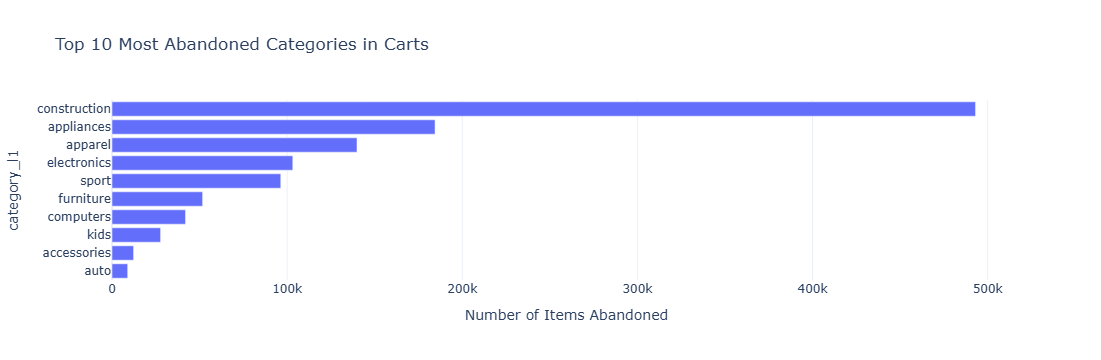

In [20]:
fig_abandon_cat = px.bar(top_abandoned_cats, x = top_abandoned_cats.values, y= top_abandoned_cats.index,
                        orientation = 'h', title = 'Top 10 Most Abandoned Categories in Carts',
                        labels={'x': 'Number of Items Abandoned','y': 'Category'})
fig_abandon_cat.update_layout(yaxis={'categoryorder':'total ascending'})
fig_abandon_cat.show()

### 3.5 Visualize Abandoned Brands

In [21]:
fig_abandon_brand = px.bar(top_abandoned_brands,x = top_abandoned_brands.values,y = top_abandoned_brands.index,
                          orientation = 'h',title = 'Top 10 Most Abandoned Brands in Carts',
                           labels = {'x': 'Number of Items Abandoned','y': 'Brand'})
fig_abandon_brand.update_layout(yaxis={'categoryorder':'total ascending'})
fig_abandon_brand.show()

### 3.6 Product-Level Conversion Analysis (View-to-Cart)

Calculating product-level conversion rates...
Calculation complete.
--- Top Converting Products (View-to-Cart) ---
        product_id  view_sessions  view_and_cart_sessions  \
58554     25505773           22.0                    10.0   
57881     24601808           31.0                    14.0   
59749     26012850          234.0                    98.0   
80640     50500132           23.0                     9.0   
84676    100008609           34.0                    12.0   
35690     12901426           56.0                    19.0   
13139      5000802           34.0                    11.0   
42496     16200203           66.0                    21.0   
16253      6201371           38.0                    12.0   
33262     12707276           32.0                    10.0   
105761   100078144           55.0                    17.0   
45964     17500791           23.0                     7.0   
35641     12900125           69.0                    21.0   
18232      6801280           56

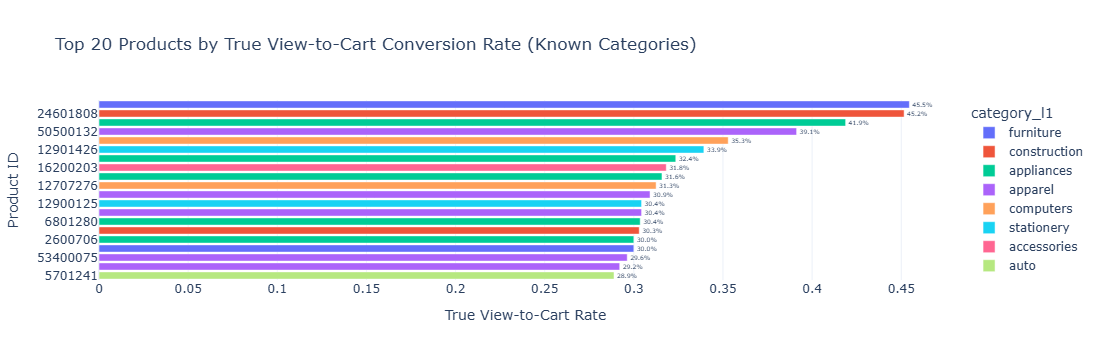

In [22]:
# --- 3.6 Calculate Product-Level Conversion & Direct-to-Cart --- 
print("Calculating product-level conversion rates...")

# 1. Aggregate events by both product and session
events_by_product_session = df.groupby(['product_id', 'user_session']).agg(
    viewed=('is_view', 'max'),
    carted=('is_cart', 'max')
).reset_index()

# 2. Calculate metrics based on this aggregation
viewed_sessions = events_by_product_session[events_by_product_session['viewed'] == 1].groupby('product_id').size()

viewed_and_carted_sessions = events_by_product_session[
    (events_by_product_session['viewed'] == 1) & (events_by_product_session['carted'] == 1)
].groupby('product_id').size()

direct_to_cart_sessions = events_by_product_session[
    (events_by_product_session['viewed'] == 0) & (events_by_product_session['carted'] == 1)
].groupby('product_id').size()

# 3. Combine into a new DataFrame
product_conversion = pd.DataFrame({
    'view_sessions': viewed_sessions,
    'view_and_cart_sessions': viewed_and_carted_sessions,
    'direct_to_cart_sessions': direct_to_cart_sessions
}).fillna(0) 

# 4. Calculate the true conversion rate
product_conversion['true_conversion_rate'] = (product_conversion['view_and_cart_sessions'] / product_conversion['view_sessions']).fillna(0)

# 5. Filter out noise: only look at products viewed in at least 20 different sessions
product_conversion_filtered = product_conversion[product_conversion['view_sessions'] >= 20].copy()

# 6. Merge with product details
product_details = df[['product_id', 'brand', 'category_l1', 'price']].drop_duplicates('product_id')
product_conversion_final = product_conversion_filtered.merge(
    product_details,
    on='product_id'
)

# --- 7. FILTER OUT "Unknown" and "None" categories ---
# We clean the names and then filter them out
product_conversion_final['category_l1_cleaned'] = product_conversion_final['category_l1'].str.strip().str.lower()
filter_list = ['unknown', 'none']

known_products_conversion = product_conversion_final[
    ~product_conversion_final['category_l1_cleaned'].isin(filter_list)
]
print("Calculation complete.")


top_converting_products = known_products_conversion.sort_values(by='true_conversion_rate', ascending=False)
print("--- Top Converting Products (View-to-Cart) ---")
print(top_converting_products.head(15))


# --- Visualize Top Converting Products ---
print("\nPlotting 'Top Converting Products'...")

# Create a combined text column for the hover tooltip
top_converting_products['product_label'] = 'Brand: ' + top_converting_products['brand'] + \
                                           '<br>Category: ' + top_converting_products['category_l1'] + \
                                           '<br>Price: $' + top_converting_products['price'].astype(str)

# Plot the top 20 from the FILTERED DataFrame
fig_product_conv = px.bar(
    top_converting_products.head(20),
    x='true_conversion_rate',
    y='product_id',
    orientation='h',
    title='Top 20 Products by True View-to-Cart Conversion Rate (Known Categories)',
    labels={'true_conversion_rate': 'True View-to-Cart Rate', 'product_id': 'Product ID'},
    hover_name='product_label', 
    color='category_l1', 
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig_product_conv.update_layout(yaxis={'categoryorder':'total ascending', 'type': 'category'})
fig_product_conv.update_traces(texttemplate='%{x:.1%}', textposition = 'outside')
fig_product_conv.show()



### Product-Level Conversion Analysis Insight

This analysis goes deeper to find products with the highest view-to-cart conversion rates.

Code: It calculated metrics for each product, including total view sessions, total cart sessions, and a "true conversion rate" (view_and_cart_sessions / view_sessions). It also identified products added directly to carts without a view in the same session.

#### Key Findings (from code output):

- The analysis produced a table of the "Top Converting Products." For example, the top product (ID 25505773) had a 45.45% view-to-cart rate (10 carts from 22 view sessions).

### 3.7 Visualize Top Direct-to-Cart Products

In [23]:
# --- Visualize Top Direct-to-Cart Products ---
top_direct_to_cart = known_products_conversion.sort_values(by='direct_to_cart_sessions', ascending=False)
# Create a combined text column for the hover tooltip
top_direct_to_cart['product_label'] = 'Brand: ' + top_direct_to_cart['brand'] + \
                                      '<br>Category: ' + top_direct_to_cart['category_l1'] + \
                                      '<br>Price: $' + top_direct_to_cart['price'].astype(str)

fig_direct_cart = px.bar(
    top_direct_to_cart.head(20),
    x='direct_to_cart_sessions',
    y='product_id',
    orientation='h',
    title='Top 20 Products Added Directly to Cart (No View in Session)',
    labels={'direct_to_cart_sessions': 'Direct-to-Cart Sessions', 'product_id': 'Product ID'},
    hover_name='product_label', 
    color='category_l1',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig_direct_cart.update_layout(yaxis={'categoryorder':'total ascending', 'type': 'category'})

fig_direct_cart.show()

## 4. Sales Performance Analysis

### 4.1 Create Purchase Database

In [24]:
# Create Purchase Database
purchases_df = df[df['is_purchase'] == 1].copy()
print(f'Total Purchases Made:{len(purchases_df)}')
print(f'Total Revenue: ${purchases_df['revenue'].sum():.2f}')
print(f'Average Order Value (AOV): ${purchases_df['revenue'].mean():.2f}')

Total Purchases Made:834975
Total Revenue: $261025980.58
Average Order Value (AOV): $312.62


### 4.2 Top 10 Categories by Revenue

In [25]:
# Top Categories by Revenue
top_cats_revenue_all = purchases_df.groupby('category_l1')['revenue'].sum().nlargest(11).reset_index()

# Clean the category names and filter out 'unknown' and 'none'
top_cats_revenue_all['category_l1_cleaned'] = top_cats_revenue_all['category_l1'].str.strip().str.lower()
filter_list = ['unknown', 'none']

top_cats_revenue = top_cats_revenue_all[~top_cats_revenue_all['category_l1_cleaned'].isin(filter_list)].head(10)


print("--- Top Categories DataFrame (Cleaned) ---")
print(top_cats_revenue)
print("-" * 30)


fig_top_cat = px.bar(
    top_cats_revenue,
    x='revenue',
    y='category_l1',
    orientation='h',
    title='Top 10 Categories by Revenue',
    labels={'category_l1': 'Category'}
)
fig_top_cat.update_layout(yaxis={'categoryorder':'total ascending'})
fig_top_cat.show()

--- Top Categories DataFrame (Cleaned) ---
     category_l1       revenue category_l1_cleaned
0   construction  1.760579e+08        construction
1     appliances  3.451680e+07          appliances
2    electronics  1.787099e+07         electronics
3        apparel  9.261375e+06             apparel
4          sport  6.575002e+06               sport
6      computers  4.865908e+06           computers
7      furniture  3.148919e+06           furniture
8           kids  1.404591e+06                kids
9           auto  1.149919e+06                auto
10   accessories  3.978684e+05         accessories
------------------------------


### 4.3 Top 10 Brands by Revenue

In [26]:
top_brands_revenue = purchases_df.groupby('brand')['revenue'].sum().nlargest(11).reset_index()
top_brands_revenue = top_brands_revenue[top_brands_revenue['brand'] != 'Unknown']

fig_top_brand = px.bar(
    top_brands_revenue,
    x = 'revenue',
    y = 'brand',
    orientation = 'h',
    title = 'Top 10 Brands by Revenue',
    labels = {'brand': 'Brand'}
)
fig_top_brand.update_layout(yaxis={'categoryorder': 'total ascending'})
fig_top_brand.show()

### 4.4 Revenue Distribution

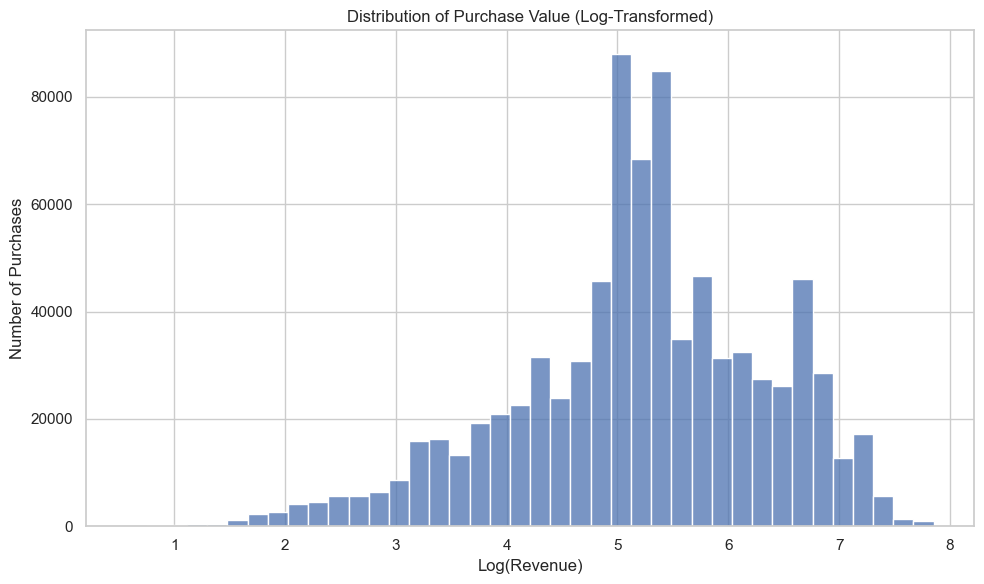

In [27]:
purchases_df['log_revenue'] = np.log1p(purchases_df['revenue'])

plt.figure(figsize=(10, 6))

sns.histplot(
    data=purchases_df,
    x='log_revenue',
    bins=40,       
    kde=False      
)

plt.title('Distribution of Purchase Value (Log-Transformed)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Number of Purchases')

plt.tight_layout()
plt.show()
# # Using seaborn's histplot because the prior Matplotlib/PyPlot version produced a large output file.

### 4.5 Activity by Day of Week

In [28]:
# --- 4.5 Revenue by Hour and Day of Week ---
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sum events by weekday
view_by_day = df.groupby('event_weekday')['is_view'].sum().reindex(weekday_order)
cart_by_day = df.groupby('event_weekday')['is_cart'].sum().reindex(weekday_order)
purchase_by_day = df.groupby('event_weekday')['is_purchase'].sum().reindex(weekday_order)

# Combine into a DataFrame for plotting
activity_by_day = pd.DataFrame({
    'Views': view_by_day,
    'Carts': cart_by_day,
    'Purchases': purchase_by_day
}).reset_index()

activity_by_day_melted = activity_by_day.melt(id_vars='event_weekday', var_name='Event Type', value_name='Count')

print("--- Data for 'Activity by Day' Chart ---")
print(activity_by_day_melted.head())
print("-" * 30)

# Plot
fig_day = px.bar(
    activity_by_day_melted,
    x='event_weekday',
    y='Count',
    color='Event Type',
    title='Total Activity by Day of Week',
    labels={'event_weekday': 'Day of Week'},
    barmode='group'
)
fig_day.show()


--- Data for 'Activity by Day' Chart ---
  event_weekday Event Type    Count
0        Monday      Views  6694525
1       Tuesday      Views  6667466
2     Wednesday      Views  7754144
3      Thursday      Views  8351002
4        Friday      Views  8733240
------------------------------


### 4.6 Activity by Hour of Day

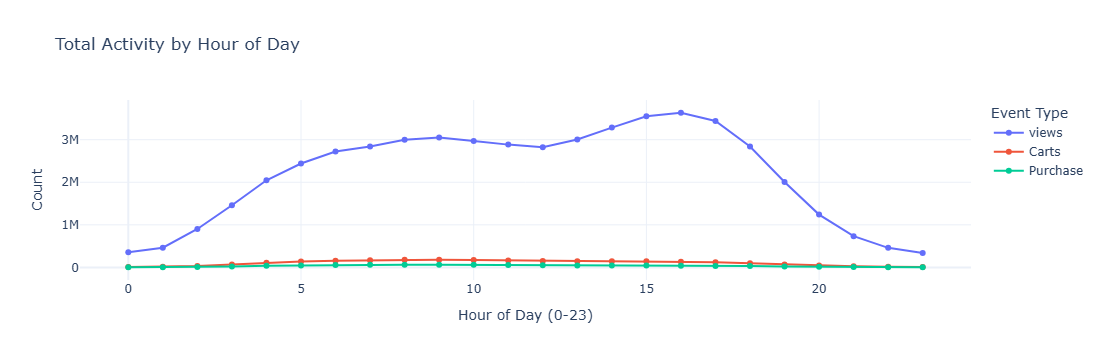

In [29]:
# Sum events by hour
view_by_hour = df.groupby('event_hour')['is_view'].sum()
cart_by_hour = df.groupby('event_hour')['is_cart'].sum()
purchase_by_hour = df.groupby('event_hour')['is_purchase'].sum()

# Combine into a DataFrame
activity_by_hour = pd.DataFrame({
    'views': view_by_hour,
    'Carts': cart_by_hour,
    'Purchase': purchase_by_hour
}).reset_index()

activity_by_hour_melted = activity_by_hour.melt(id_vars = 'event_hour', var_name = 'Event Type', value_name = 'Count')

fig_hour = px.line(
    activity_by_hour_melted,
    x = 'event_hour',
    y = 'Count',
    color = "Event Type",
    title = 'Total Activity by Hour of Day',
    labels = {'event_hour': 'Hour of Day (0-23)'},
    markers = True
)
fig_hour.show()

## Sales Performance Analysis
- Total purchases: 834,975
- Total revenue: $261,025,980.58
- Average order value (AOV): $312.62
- Top category (category_l1): construction — $176,057,900 (~67.45% of revenue).
- 2nd category: appliances — $34,516,800 (~13.22% of revenue).
- Top 2 categories combined: ~80.67% of total revenue (extreme concentration).

### Views by weekday (weekdays only in chart):
- Monday 6,694,525 (17.52%)
- Tuesday 6,667,466 (17.45%) 
- Wednesday 7,754,144 (20.30%)
- Thursday 8,351,002 (21.86%)
- Friday 8,733,240 (22.86%)

### Key Insights
- You are dangerously dependent on a single category (construction ~67%). 
- Top-2 categories = ~80.7% of revenue.
- Traffic concentration: peak engagement late week (Thu–Fri).
- 22.9% of weekly weekday views occur on Friday alone; Thursday+Friday ~44.7%.

## 5. Cohort Analysis

### 5.1 Prepare Cohort Data

In [30]:
print('--- Starting Cohort Analysis ---')
df_purchases = df[df['is_purchase'] == 1].copy()
df_purchases['purchase_day'] = df_purchases['event_time'].dt.to_period('D')
df_purchases['acquisition_day'] = df_purchases.groupby('user_id')['event_time'].transform('min').dt.to_period('D')

cohort_data = df_purchases.groupby(['acquisition_day','purchase_day']).agg(n_customers = ('user_id','nunique')).reset_index()

cohort_data['cohort_index'] = (cohort_data['purchase_day'] - cohort_data['acquisition_day'])
cohort_data['cohort_index'] = cohort_data['cohort_index'].apply(lambda x: x.n)

cohort_pivot = cohort_data.pivot_table(
    index = 'acquisition_day',
    columns = 'cohort_index',
    values = 'n_customers'
)
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
print("--- Cohort Data Prepared ---")

--- Starting Cohort Analysis ---
--- Cohort Data Prepared ---


### 5.2 Visualize Daily Retention Heatmap

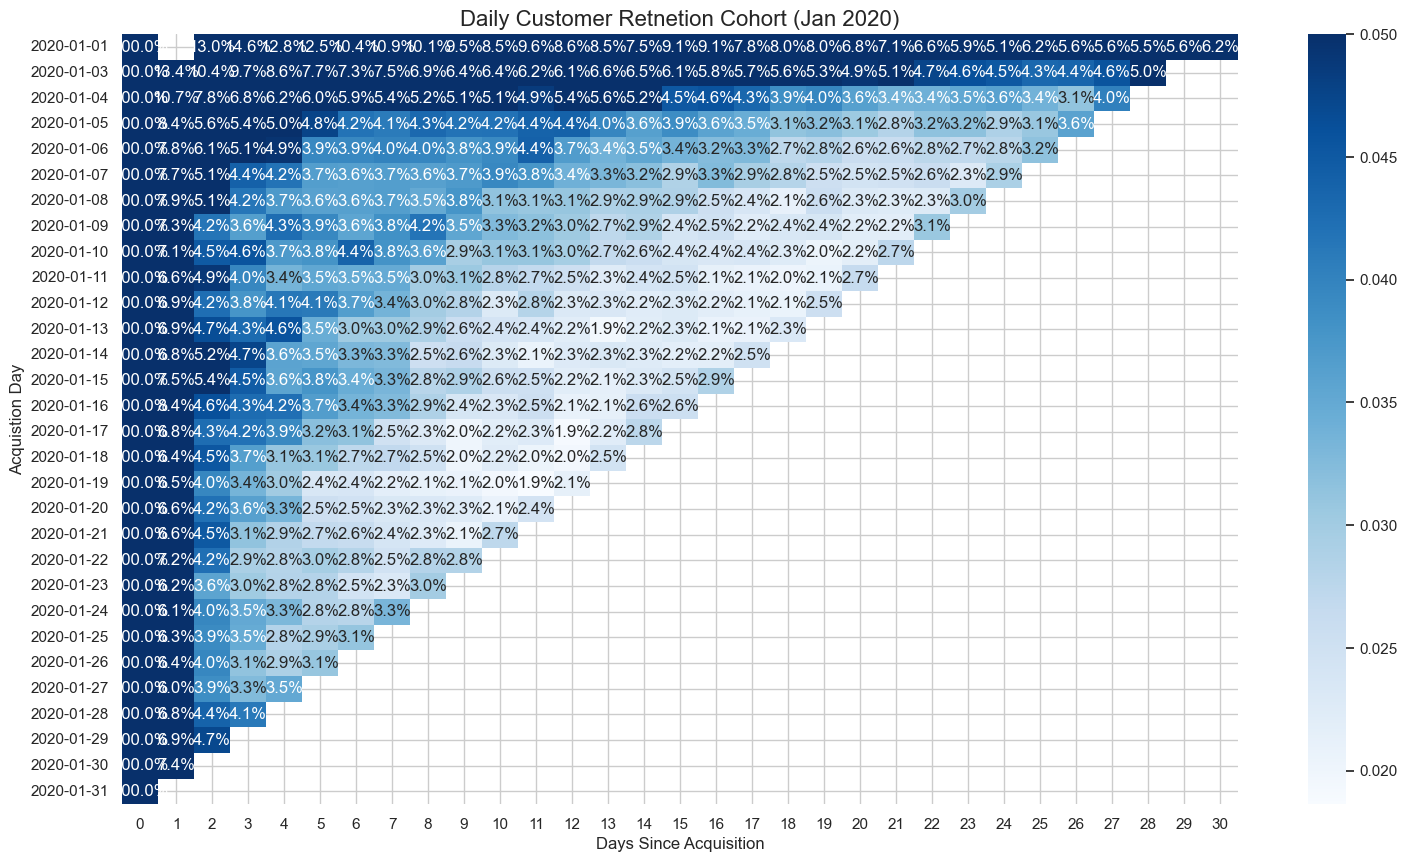

In [31]:
plt.figure(figsize =(18,10))
sns.heatmap(
    retention_matrix,
    annot = True,
    fmt = '.1%',
    cmap = 'Blues',
    vmax = 0.05
)
plt.title('Daily Customer Retnetion Cohort (Jan 2020)', fontsize = 16)
plt.ylabel('Acquistion Day')
plt.xlabel('Days Since Acquisition')
plt.show()

### Cohort Analysis Insight
- This section tracks groups of users over time to measure customer retention and loyalty.

- A "cohort" was defined as a group of users who made their first-ever purchase on the same day (acquisition_day).

- It then pivoted the data to see how many of these users from each cohort returned to make another purchase on subsequent days (Day 1, Day 2, Day 3, etc.).

- A retention matrix was calculated by dividing the number of returning users by the original size of the cohort.

- Visualization (Code): The analysis generated a sns.heatmap of this retention matrix.

#### Key Findings (from code output):

- The heatmap shows the percentage of each cohort that returned on a given day after their first purchase.

- The vmax was set to 0.05 (5%), indicating that retention rates are generally low, with the highest retention (outside of Day 0) being in the 1-5% range for the first few days, and dropping off after that.

## 6. Data Modeling 

### 6.1 Engineer Features at User-Level

In [32]:
print('--- Predictive Modeling ---')
print('Creating User-Level Features for Modeling')
user_features = df.groupby('user_id').agg(
    total_views = ('is_view','sum'),
    total_carts = ('is_cart','sum'),
    total_purchases = ('is_purchase', 'sum'),
    total_revenue = ('revenue','sum'),
    unique_sessions = ('user_session', 'nunique')
)
df_views = df[df['is_view'] == 1]
df_carts = df[df['is_cart'] == 1]

view_stats = df_views.groupby('user_id').agg(
    avg_price_of_viewed_items = ('price', 'mean'),
    unique_categories_viewed = ('category_l1','nunique' ),
    unique_brands_viewed = ('brand', 'nunique')
)

cart_stats = df_carts.groupby('user_id').agg(
    avg_price_carted_items = ('price','sum'),
    unique_categories_carted = ('category_l1','nunique'),
    unique_brands_carted = ('brand','nunique')
)

# Combine All Features

user_features = user_features.join(view_stats).join(cart_stats).fillna(0)                
user_features['view_to_cart_ratio'] = user_features['total_carts'] / user_features['total_views']

# Handle Division by 0 for User with 0 Views
user_features['view_to_cart_ratio'] = user_features['view_to_cart_ratio'].fillna(0).replace([np.inf, -np.inf], 0)

# Define Target Varible
user_features['target'] = (user_features['total_purchases'] > 0).astype(int)


print(f'Created featuers for {len(user_features)} unique_users')
print(f"Purchase Rate: {user_features['target'].mean():.2%}")

--- Predictive Modeling ---
Creating User-Level Features for Modeling
Created featuers for 4385985 unique_users
Purchase Rate: 8.19%


### 6.2 Train-Test Split & Scaling

In [33]:
print('--- Splitting & Scaling Data for Model ---')
feature_list = ['total_views', 
                'total_carts',
                'unique_sessions',
                'avg_price_of_viewed_items',
                'unique_categories_viewed',
                'avg_price_carted_items',
                'unique_categories_carted',
                'unique_brands_carted',
                'view_to_cart_ratio'
               ]

missing_cols = [c for c in feature_list if c not in user_features.columns]
if missing_cols:
    raise KeyError(f"Missing expected feature columns: {missing_cols}")

    
# 1. Train/Test Split 
X = user_features[feature_list]
y = user_features['target']


# Check dtypes and coerce numeric columns (if some are strings of numbers)
for c in X.columns:
    if not pd.api.types.is_numeric_dtype(X[c]):
        try:
            X[c] = pd.to_numeric(X[c], errors='coerce')
            print(f"Coerced {c} -> numeric")
        except Exception:
            print(f"WARNING: column {c} is non-numeric and could not be coerced")

# Report missing values and impute simple strategy (median) for numeric features
nulls = X.isnull().sum()
if nulls.sum() > 0:
    print("Null counts (per feature):")
    print(nulls[nulls>0])
    # quick, defensible imputation for a baseline
    X = X.fillna(X.median())
    
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2,random_state = 42,stratify = y
)
print("Train/Test Shapes:", X_train.shape, X_test.shape, y_train.value_counts(normalize = True).to_dict())

# 2. Baseline Classifier
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
dummy_proba = dummy.predict_proba(X_test)[:,1] if hasattr(dummy, "predict_proba") else None
print("Baseline (most frequent) - if predict_proba available, ROC-AUC: ",
      roc_auc_score(y_test, dummy_proba) if dummy_proba is not None else "N/A")


--- Splitting & Scaling Data for Model ---
Train/Test Shapes: (3508788, 9) (877197, 9) {0: 0.9181244349900878, 1: 0.08187556500991225}
Baseline (most frequent) - if predict_proba available, ROC-AUC:  0.5


### 6.3 Pipeline + GridSearchCV

In [34]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
])
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10],
    'clf__min_samples_leaf': [1, 5]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs = 1, verbose = 1)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_model = search.best_estimator_

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}


In [35]:
joblib.dump(best_model, "best_randomforest_model.pkl")

['best_randomforest_model.pkl']

### 6.4 Evaluate Model Performance

In [36]:
y_proba = best_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
print(f"Test ROC-AUC: {roc:.4f}")
print(f"Test Average Precision (PR-AUC): {ap:.4f}")

# 5.Precision-Recall Curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

Test ROC-AUC: 0.9741
Test Average Precision (PR-AUC): 0.7381


### 6.5 Plot PR Curve

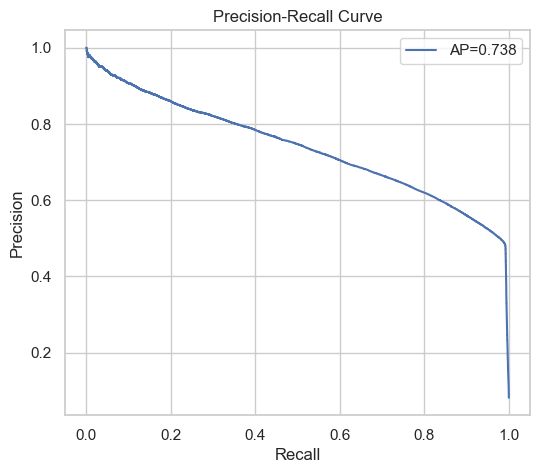

Best threshold from grid: 0.860  F1: 0.700


In [37]:
# 4) Plot PR curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


th_grid = np.linspace(0.0, 1.0, 101)
f1_grid = []
for t in th_grid:
    pred = (y_proba >= t).astype(int)
    f1_grid.append(f1_score(y_test, pred))

best_idx = int(np.argmax(f1_grid))
best_threshold = float(th_grid[best_idx])
print(f"Best threshold from grid: {best_threshold:.3f}  F1: {f1_grid[best_idx]:.3f}")

chosen_threshold = best_threshold

### 6.6 Confusion Matrix at Threshold

Confusion Matrix (rows: true, cols: pred):
 [[767016  38360]
 [ 12536  59285]]

Classification Report at chosen threshold:
               precision    recall  f1-score   support

           0      0.984     0.952     0.968    805376
           1      0.607     0.825     0.700     71821

    accuracy                          0.942    877197
   macro avg      0.796     0.889     0.834    877197
weighted avg      0.953     0.942     0.946    877197



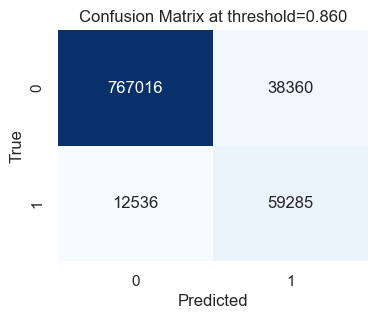

In [38]:
y_preds_thresh = (y_proba >= chosen_threshold).astype(int)
cm = confusion_matrix(y_test, y_preds_thresh)
print("Confusion Matrix (rows: true, cols: pred):\n", cm)
print("\nClassification Report at chosen threshold:\n", classification_report(y_test, y_preds_thresh, digits=3))

# plot confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix at threshold={chosen_threshold:.3f}')
plt.show()

### 6.7 Feature Importance

Top 10 features by importance:
 view_to_cart_ratio           0.333832
unique_brands_carted         0.206192
unique_categories_carted     0.202388
total_carts                  0.167637
avg_price_carted_items       0.072801
total_views                  0.009403
unique_sessions              0.005429
avg_price_of_viewed_items    0.001404
unique_categories_viewed     0.000915
dtype: float64


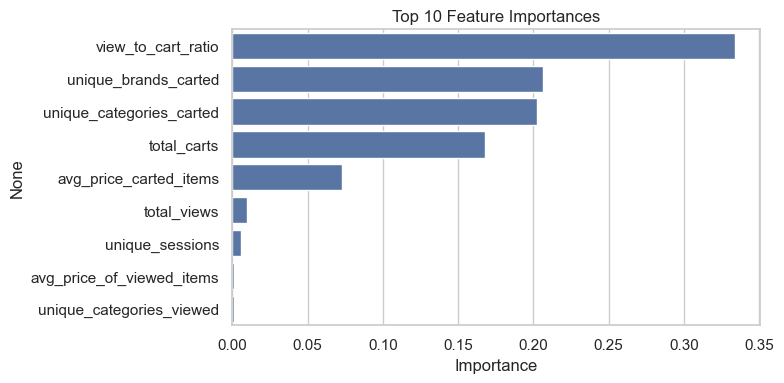

In [39]:
rf = best_model.named_steps['clf']
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 features by importance:\n", importances.head(10))

plt.figure(figsize=(8,4))
sns.barplot(x=importances.head(10).values, y=importances.head(10).index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Predictive Modeling
- This section builds a machine learning model to predict whether a user will make a purchase.

#### Objective: 
- Predict if a user will ever make a purchase (target = 1) or not (target = 0) based on their aggregated behavior.

### Feature Engineering
Code: Instead of looking at single events, the data was aggregated for each of the 4.38 million unique users.

- Features Created:
total_views, total_carts, total_purchases
avg_price_of_viewed_items, avg_price_carted_items
unique_sessions, unique_categories_viewed, unique_brands_carted
view_to_cart_ratio (total_carts / total_views)

#### Dataset:
- Total Users: 4,385,985

- Purchase Rate (Class Balance): 8.19% of users made a purchase.


### Modeling & Evaluation
- Model: A RandomForestClassifier was chosen, placed within a Scikit-learn Pipeline.
- Tuning: GridSearchCV was used to find the best model parameters, optimizing for roc_auc (a good metric for imbalanced data).
- Best Parameters (from code output): {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}

#### Model Performance (from code output):
- Test ROC-AUC: 0.9741 (This is an excellent score, showing the model is very good at distinguishing between purchasers and non-purchasers).
- Test Average Precision (PR-AUC): 0.7381 (This is also a strong score, and more informative than ROC-AUC for imbalanced data).

### Classification Report:
- The model was tuned to find the best F1-score, which occurred at a probability threshold of 0.860.
- At this threshold, the model achieved an F1-score of 0.700 for the positive (purchase) class.
- Precision (Purchase Class): 0.607 (When it predicts a purchase, it's correct 60.7% of the time).
- Recall (Purchase Class): 0.825 (It successfully finds 82.5% of all actual purchasers).

### Feature Importance
- Code: The feature importances were extracted from the best RandomForestClassifier.

#### Key Findings (from code output): The model's predictions are overwhelmingly driven by carting behavior.
- view_to_cart_ratio: 33.4% importance
- unique_brands_carted: 20.6% importance
- unique_categories_carted: 20.2% importance
- total_carts: 16.8% importance
- avg_price_carted_items: 7.3% importance

### Conclusion: 
The strongest predictor of a future purchase is a user's past engagement with the cart. Users who add many different items, brands, and categories to their cart, and who have a high view-to-cart ratio, are a strong signal of purchase intent.